# Open Source Spotlight: Open-FDD for automated HVAC fault detection

Fault detection and diagnosis (FDD) is a critical part of building operations and maintenance. There may not be many opportunities in the field for general approaches to this nuanced issue, but it turns out some aspects can be standardized. In particular, [ASHRAE has laid out some guidelines for AHU operations](https://www.ashrae.org/news/ashraejournal/guideline-36-2021-what-s-new-and-why-it-s-important), and specific scenarios where faults commonly occur. These guidelines include specific equations that test whether a fault condition is met. 

[Ben Bartling](https://github.com/bbartling) has taken up the mantle to code these guidelines into an [open source package under active development called `open-fdd`](https://github.com/bbartling/open-fdd) (FDD is the industry initialism for "fault detection and diagnosis", and this is an open source package. Smash those terms together like some kind of jargony sandwich, and you get this very apropos name). I tested the package out on some of our building data, and I've been very impressed so far. I wanted to share a use case to show what it takes to test of some of those common AHU faults.

My target reader for this article is someone who has read so far and goes "heck yeah, that sounds awesome. I have never even seen this package, but I definitely want to try it out. Tell me, magic computer tutorial man, how do I use it??" Fortunately, the package is well-documented and easy to use. However, it assumes an ideal scenario, where you just have all the data it needs, in exactly the right format. Building system data can be complicated, and it may not be perfectly straightforward to get all the right data in the right format that `open-fdd` wants (it wasn't for me, anyway), so I'll show you one use case for doing so. 

This process can be easily generalized and automated for regular reports and alerts -- maybe use it to send yourself a regular email or slack message or something if anything gets flagged as being wonky. I chose Fault Condition 9, which tests AHUs running in economize mode, and the fault occurs when outside air isn't cool enough for free cooling.

## Orienting to open-fdd

Using `open-fdd` is super straightforward. You choose the fault condition you want, find the relevant info on the [readme](https://github.com/bbartling/open-fdd) and/or in the code, and figure out what sensors you need. Our choice, Fault Condition 9, required 5 sensors: outside air temperature, supply air temperature setpoint, supply fan speed, cooling signal, and economize mode signal.

Once you get all that data into a csv, you run a super simple command line invocation of python for the specific fault condition script you're trying to run:

    python fc9.py -i <input file name> -o <final report output name>
    
And it's that easy! So, since we know which sensors we need, the first thing on our side of the bottleneck is to figure out how those sensor types translate to our system.

## Get the right sensor types

Fortunately, the sensors required by this fault condition are pretty standard, and not too difficult to translate into our system. For context, we have our own system we use to organize and tag building data, which I've talked about in previous posts, most notably in [the first tutorial I did](https://medium.com/onboard-blog/timeseries-cleaning-and-imputation-a96ab7e45eb7). To very briefly explain our system: buildings contain stuff, equipment does stuff, and sensors measure stuff. Sensors are located on equipment, which are likewise located in buildings. Sensors are also known as "points" in our system.

We maintain all these entities and their relationships, as well as other aspects of the data like measurements, standardized tags etc., as part of our data model, the ontology we use to categorize all the data that comes into our system.

For fault condition 9, outside air temp (`oat`), supply air temp setpoint (`satsp`), and supply fan speed (`supply_vfd_speed`) all pretty directly translated into our system. This is easily seen by querying our data model. Here's what our collection of point types looks like:

In [2]:
# boiler plate stuff for connecting to our system:
import pandas as pd
import numpy as np
from onboard.client import OnboardClient
from onboard.client.models import PointSelector
from onboard.client.models import TimeseriesQuery
from onboard.client.dataframes import points_df_from_streaming_timeseries
from datetime import datetime, timezone, timedelta

try: # for this you can either create a key.py file with one line: api_key = 'your api key here'
    from key import api_key
except ImportError: # or you can just input your api key when you get the prompt
    api_key = input('Please enter your api_key')

client = OnboardClient(api_key=api_key)

# the actual interesting part:

point_types = pd.DataFrame(client.get_all_point_types())

# get the names of the measurements, so we know what each sensor measures
measurements = pd.DataFrame(client.get_all_measurements())[['id','name']].rename(columns={'name':'measurement_name'})

point_types = point_types.merge(measurements, left_on='measurement_id', right_on='id', suffixes = ['', '_measurements'], how='left').drop(columns=['id_measurements'])
point_types.head()

,id,tag_name,active,measurement_id,tag_set_ids,tags,default_unit_id,measurement_name
0,124,Occupied Heating Setpoint,True,1,"[15, 2, 4, 62, 51, 55]","[air, sp, temp, zone, heating, occ]",None,Temperature
1,118,Outside Air Carbon Dioxide,True,6,"[15, 8, 1, 24]","[air, co2, sensor, outside]",None,Concentration
2,130,Return Air Temperature Setpoint,True,1,"[15, 2, 4, 63]","[air, sp, temp, return]",None,Temperature
3,84,Dual-Temp Coil Discharge Air Temperature,True,1,"[15, 36, 47, 1, 4, 250]","[air, discharge, dualTemp, sensor, temp, coil]",None,Temperature
4,81,Reheat Coil Discharge Air Temperature,True,1,"[15, 36, 44, 1, 4, 250]","[air, discharge, reheats, sensor, temp, coil]",None,Temperature


Looking at just the first few point types, the key column for our interest will be `tag_name`, though `tags` is also helpful since it can tell a bit more about what a sensor is/does. 

In [67]:
point_types[point_types.tag_name.str.contains("Outside Air Temperature$|^Speed$|Supply Air Temperature Setpoint$")]

,id,tag_name,active,measurement_id,tag_set_ids,tags,default_unit_id,measurement_name
9,76,Outside Air Temperature,True,1,"[15, 24, 1, 4]","[air, outside, sensor, temp]",None,Temperature
67,158,Speed,True,17,"[3, 12, 22]","[cmd, speed, vfd]",None,Motor Speed
331,428,Supply Air Temperature Setpoint,True,1,"[2, 122, 15, 4]","[sp, supply, air, temp]",None,Temperature


From this we can easily get the point type id, which is the unique id used to reference all points of that type.

One slightly tricky sensor to deal with here was the economizer signal. While our ontology allows for a simple binary signal for whether the economize mode is on or off, for example:

In [68]:
point_types[point_types.tag_name.str.contains("Economize Mode")]

,id,tag_name,active,measurement_id,tag_set_ids,tags,default_unit_id,measurement_name
68,168,Economize Mode,True,11,"[3, 23]","[cmd, enable]",None,On/Off


it turns out `open-fdd` actually uses continuous Outside Air Damper Position to measure when the economizer mode is on, since this air damper feeds air to the economizer. For this fault condition, it simply looks to see if the Open Air Damper Position is greater than 0, and flags those times as the economizer being on.

In [70]:
point_types[point_types.tag_name.str.contains("^Outside Air Damper Position$")]

,id,tag_name,active,measurement_id,tag_set_ids,tags,default_unit_id,measurement_name
24,148,Outside Air Damper Position,True,7,"[15, 3, 11, 24]","[air, cmd, damper, outside]",None,Position


The other tricky one was the cooling signal. This is expected to be a simple binary on/off sensor that says whether cooling was, you guessed it, on or off. Let's take a look at what might fit that bill.

In [71]:
point_types[point_types.tag_name.str.contains("(?:Cooling (?:Command|Status|Output|Coil Valve)|Cold|Chilled Water Valve)")]

,id,tag_name,active,measurement_id,tag_set_ids,tags,default_unit_id,measurement_name
66,160,Chilled Water Valve Position,True,7,"[3, 13, 16, 49]","[cmd, valve, water, chilled]",None,Position
138,239,Cooling Coil Valve Position,True,7,"[3, 13, 50, 250]","[cmd, valve, cooling, coil]",None,Position
229,327,Cooling Output,True,23,"[1, 50]","[sensor, cooling]",None,Percentage
235,332,Cooling Command,True,11,"[3, 50]","[cmd, cooling]",None,On/Off
362,459,Chilled Water Valve Status,True,15,"[1, 49, 16, 13]","[sensor, chilled, water, valve]",None,Open/Close
400,495,Chilled Water Valve Command,True,15,"[49, 3, 13, 16]","[chilled, cmd, valve, water]",None,Open/Close
401,496,Chilled Water Valve Failure Status,True,11,"[87, 49, 223, 1, 13, 16]","[alarm, chilled, failure, sensor, valve, water]",None,On/Off
402,497,Chilled Water Valve Position Sensor,True,7,"[49, 1, 13, 16]","[chilled, sensor, valve, water]",None,Position
403,689,Cold Deck Air Temperature,True,1,"[15, 217, 1, 4]","[air, coldDeck, sensor, temp]",None,Temperature
428,517,Cooling Coil Valve Command,True,15,"[3, 50, 13, 250]","[cmd, cooling, valve, coil]",None,Open/Close


While there are a few points that give that binary information (things like `Cooling Command/Status`), some of the points I came across gave continuous data about cooling, such as `Cooling Output`. Looking at the [relevant `open-fdd` code](https://github.com/bbartling/open-fdd/blob/7e98d00d427ec829b1af74ffb367fe68e96c3618/faults/__init__.py#L479), we hit the world's most inconsequential jackpot, where the only check the code makes is whether the `cooling_sig` value is equal to zero, which works for either binary or continuous numerical data. This is useful because the equipment we will eventually use only had a `Cooling Output` sensor, which is measured in percentage.

## Use our criteria to find sensors and their metadata

Now that I know the point types I want, I need to narrow down equipment in our system that have those sensors. Our `PointSelector` system shines in filtering through the thousands of possible equipment and sensors in our system. 

We start with an instance of our PointSelector class, which is really just a simple container for all the different possible criteria we could filter on. I know we'll mainly be working with AHUs, and expect some of our investigations could potentially include VAVs, so I set `query.equipment_types` to a list containing their equipment type ids.

Then, based on my explorations of point types above, I similarly include the point type ids for the five target points. `client.select_points()` on this `query` gives a list of buildings, equipment, points, etc. that fall under these criteria, and `client.get_points_by_ids(selection['points'])` gets the metadata for all the points in particular that that query returned.

In [79]:
def get_candidate_data(fault_condition):
    query = PointSelector()
    query.orgs = [3,7] # the two organizations we're looking at
    query.equipment_types = [12,7] # ahu, vav

    # point types
    oat = 76
    satsp = 428
    economizer_signal = 148 # outside air damper
    fan_speed = 158
    cooling_output = 327
    
    fault_cond_dict = {
        # 8 : [mat, sat, fan_speed, economizer_signal], # an example of another fault condition that could be tested using this function
        9  :[oat, fan_speed, satsp, economizer_signal, cooling_output],
    }
    
    query.point_types = fault_cond_dict[fault_condition]

    return(query)

FAULT_CONDITION = 9
query = get_candidate_data(FAULT_CONDITION)
selection = client.select_points(query)
sensor_metadata = pd.DataFrame(client.get_points_by_ids(selection['points']))

len(set(sensor_metadata.equip_id)) # num of equipment represented here

1418

The `PointSelector` system gave us *all* the points and equipment that might fit any subset of these criteria, representing 1400+ equipment. This means, for example, it could return an AHU that just has an outside air temp sensor but none of the other four sensors we need. So the trick now is to crosstabulate between each sensor's type and it's corresponding unique equipment id, to tally how many of each sensor type any particular equipment has. Pandas' `crosstab` function is super handy here. A table is worth a thousand words:

In [81]:
# cross tabulate by equip id and point type, to find those equip that have at least one of all required sensors
ctab = pd.crosstab(sensor_metadata.equip_id, sensor_metadata.type)
ctab

type,Cooling Output,Outside Air Damper Position,Outside Air Temperature,Speed,Supply Air Temperature Setpoint
equip_id,,,,,
12224,0,1,0,0,1
12225,0,1,0,0,0
13893,0,1,1,3,1
13894,0,1,1,3,1
14162,0,1,1,0,0
...,...,...,...,...,...
38336,0,0,0,0,1
38337,0,0,0,0,1
38338,0,0,0,0,1


Case in point, `12224` only has `oat` and `satsp`, and none of the other critical points. So let's filter this new dataframe to include only those rows with at least one of each type of sensor.

(Note: we could broaden our search to include AHUs that don't have an integrated supply fan and instead have a child equip that is a fan -- and thus would have all these sensors except `Fan Speed` -- but that's complicated, and we found an equip that showed some faults, so that's good enough for our purposes here.)

In [83]:
# find only those with all the target sensors
ctab = ctab[ctab.apply(lambda row: all(row > 0), axis=1)]
ctab

type,Cooling Output,Outside Air Damper Position,Outside Air Temperature,Speed,Supply Air Temperature Setpoint
equip_id,,,,,
34000,1,2,5,7,14
36823,1,1,3,1,3
36824,1,1,3,1,3
36825,1,1,3,1,3


Ah, great, now our selection is reduced from 1400+ equipment to only four to choose from. Again, for brevity I'm cheating a little bit: from my previous explorations, I already know only one of these AHUs shows a fault, so let's just fast forward to choosing that one, `36823`.

In [84]:
EQUIP_ID = 36823

target_points_metadata = sensor_metadata[(sensor_metadata.equip_id == EQUIP_ID) & (sensor_metadata.point_type_id.isin(query.point_types))]

target_points_metadata[['id','name','type','equip_id']].sort_values('type')

,id,name,type,equip_id
1607,432985,Cooling Capacity Status,Cooling Output,36823
1604,432968,Outdoor Air Damper Position,Outside Air Damper Position,36823
1600,432945,Outdoor Air Temperature,Outside Air Temperature,36823
1605,432975,Outdoor Air Temperature Active,Outside Air Temperature,36823
1606,432976,Outdoor Air Temperature BAS,Outside Air Temperature,36823
1601,432953,Supply Fan Speed Command,Speed,36823
1602,432959,Supply Air Temperature Setpoint BAS,Supply Air Temperature Setpoint,36823
1603,432960,Supply Air Temperature Setpoint Local,Supply Air Temperature Setpoint,36823
1608,432988,Supply Air Temperature Setpoint Active,Supply Air Temperature Setpoint,36823


We see duplicated `oat` and `satsp` points, so we will have to choose them based on other criteria. It looks like whoever set up this building differentiated these using the `name` column, so we will use that to choose a single unique point from each set of duplicates. I also took a look at the values themselves to make sure I chose a reasonable value, but won't show that process, again for brevity. This is also much more straightforward if you work directly with the building and know what the points are, or know where they're documented, so you can be sure you're looking at the right points.

## Query the timeseries data

So, now we choose only the right points, query the timeseries data, then rename the columns from their sensor IDs to the names the `open-fdd` expects.

In [29]:
# drop those duplicated points that end in "BAS" or "Active"
target_points_metadata = target_points_metadata[target_points_metadata.name.str.contains("BAS|Active$") == False]
target_points_ids = target_points_metadata.id.tolist()

# get start and end times from the earliest first_updated and latest last_updated cols
start_time = target_points_metadata['first_updated'].apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).min()
end_time = target_points_metadata['last_updated'].apply(lambda x: datetime.fromtimestamp(x/1000, timezone.utc)).max()

# build and perform the query
ts_query = TimeseriesQuery(point_ids = target_points_ids, start = start_time, end = end_time)
query_results = client.stream_point_timeseries(ts_query)

print("retrieving timeseries")
data = points_df_from_streaming_timeseries(query_results)
data = data.set_index(pd.to_datetime(data.timestamp)).drop(columns="timestamp") # format timestamp index

# rename using point name, put it into the format expected by open-fdd
def get_point_names_from_metadata(metadata):
    nd = {
        "Outdoor Air Temperature" : "oat",
        "Supply Air Temperature Setpoint Local" : "satsp",
        "Outdoor Air Damper Position" : "economizer_sig",
        "Supply Fan Speed Command" : "supply_vfd_speed",
        "Cooling Capacity Status" : "cooling_sig",
    }

    names_df = metadata[['id', 'name']].copy(deep=True)
    names_df['name'] = names_df['name'].apply(lambda x: nd.get(x, 'drop'))
    names_dict = {k:v for (k,v) in zip(names_df['id'], names_df['name'])}

    return(names_dict)

names_dict = get_point_names_from_metadata(target_points_metadata)
named_data = data.rename(columns=names_dict)
named_data.head()

retrieving timeseries


,supply_vfd_speed,satsp,economizer_sig,oat,cooling_sig
timestamp,,,,,
2022-05-09 20:40:29.247000+00:00,90.0,69.803333,NaN,66.193669,NaN
2022-05-09 20:40:29.950000+00:00,NaN,NaN,0.0,NaN,NaN
2022-05-09 20:40:30.384000+00:00,NaN,NaN,NaN,NaN,0.0
2022-05-09 20:41:31.826000+00:00,NaN,NaN,NaN,66.145762,NaN
2022-05-09 20:41:31.827000+00:00,90.0,69.803333,NaN,NaN,NaN


Now we just need to resample to align timestamps (as we've talked about in [previous notebooks](https://github.com/onboard-data/notebooks/blob/dev/04_timeseries_cleaning_and_imputation.ipynb)).

In [85]:
five_minute_data = named_data.resample('5T').mean() # 'T' is the interval symbol for "minutes". Don't ask me why.

five_minute_data.index = five_minute_data.index.to_series().apply(lambda x: x.strftime('%Y/%m/%d %I:%M %p')) # set proper datetime format for open-fdd
five_minute_data.index = five_minute_data.index.set_names(['Date']) # set index name that open-fdd expects

# # look at data
five_minute_data.head()

,supply_vfd_speed,satsp,economizer_sig,oat,cooling_sig
Date,,,,,
2022/05/09 08:40 PM,90.0,69.803333,0.0,66.413114,0.0
2022/05/09 08:45 PM,90.0,69.803333,0.0,67.408688,0.0
2022/05/09 08:50 PM,90.0,69.803333,0.0,67.391985,0.0
2022/05/09 08:55 PM,90.0,69.803333,0.0,66.854845,0.0
2022/05/09 09:00 PM,90.0,69.803333,0.0,66.380386,0.0


Always good to visualize your data as well, just to get some more intuition that everything at least looks plausible:

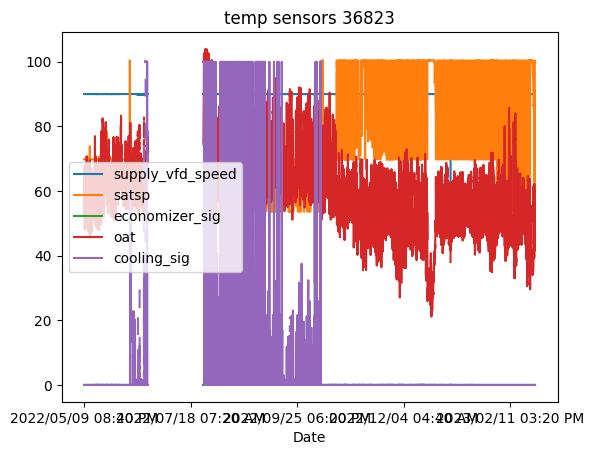

In [32]:
ax = five_minute_data.plot(title=f"temp sensors {EQUIP_ID}")

And now let's write a csv and use that when we run the package! Having followed `open-fdd`'s development so far, it looks like work is being done so that eventually you should be be able to easily import this package's functions directly into a python script and run them there. For now, though, the package is written to run from the command line, so it's easiest to just invoke the script via shell commands (which, fortunately, we can do within our notebook using Jupyter's magic commands).

In [86]:
CSV_FNAME = f'data/fc{FAULT_CONDITION}_case_study_{EQUIP_ID}.csv'
five_minute_data.to_csv(CSV_FNAME)

REPORT_OUTFNAME = f'fc{FAULT_CONDITION}_case_study_{EQUIP_ID}_final_report'

# open-fdd uses relative paths, and I'm not running this notebook in 
# the open-fdd directory so I had to do a couple silly little things to make 
# this directory look like what open-fdd wants:

!mkdir -p ./images
!mkdir -p ./final_report
!cp -n ../open-fdd/images/fc9_definition.png ./images/.

FC9_SCRIPT_FPATH = f'../open-fdd/fc{FAULT_CONDITION}.py'

# call the open-fdd python script
!python {FC9_SCRIPT_FPATH} -i {CSV_FNAME} -o {REPORT_OUTFNAME}

Dataset start:  [datetime.date(2022, 5, 9)]
Dataset end:  [datetime.date(2023, 2, 27)]
df column:  supply_vfd_speed - max len:  84661
df column:  satsp - max len:  84661
df column:  economizer_sig - max len:  84661
df column:  oat - max len:  84661
df column:  cooling_sig - max len:  84661
                     supply_vfd_speed      satsp  ...  cooling_sig  fc9_flag
Date                                              ...                       
2022-05-09 20:40:00              90.0  69.803333  ...          0.0         0
2022-05-09 20:45:00              90.0  69.803333  ...          0.0         0
2022-05-09 20:50:00              90.0  69.803333  ...          0.0         0
2022-05-09 20:55:00              90.0  69.803333  ...          0.0         0
2022-05-09 21:00:00              90.0  69.803333  ...          0.0         0

[5 rows x 6 columns]
       supply_vfd_speed         satsp  ...   cooling_sig      fc9_flag
count      73240.000000  73240.000000  ...  73218.000000  84661.000000
mean  

And that's it! The final report writes to a .docx, and (as of publishing) looks a little like this:

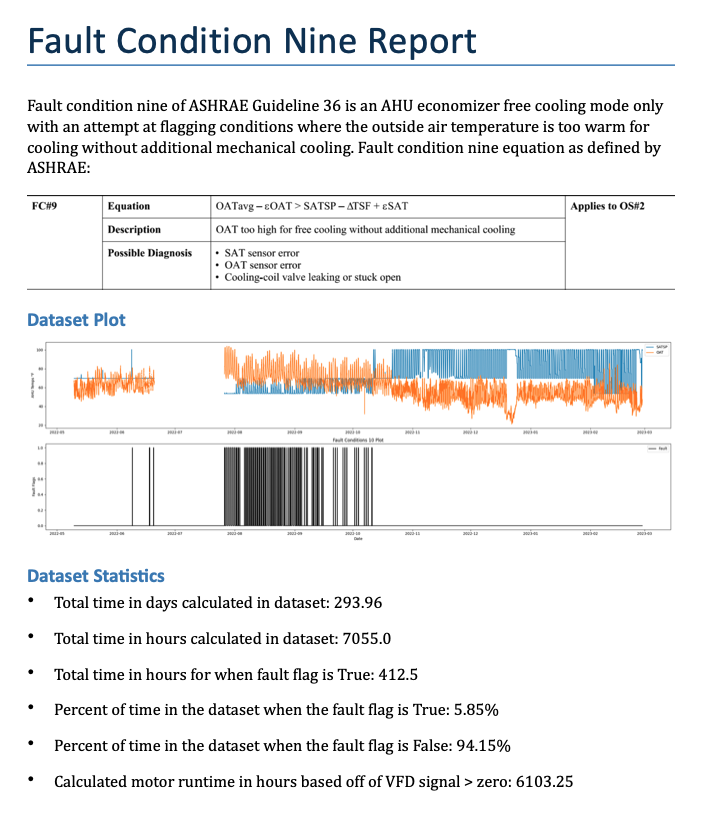

There's a second page as well with some descriptive statistics and details for when the fault flag is true, as well as (perhaps most importantly) a suggestion for what to do with this information. For example, it says this fault is True fairly frequently,

    indicating temperature sensor error or the cooling valve is stuck open or leaking causing overcooling. Trouble shoot a leaking valve by isolating the coil with manual shutoff valves and verify a change in AHU discharge air temperature with the AHU running

So, now you've got this very easy-to-parse report. From here you can take a closer look at the OAT and SAT sensors (perhaps making use of the `fc9_flag` that the report provided), and/or you could have someone on-premises implement the diagnostic troubleshooting mentioned in the above quote. Or, maybe all you need to do is send the report in an email to your boss. I'll leave those next steps up to you. But for now, this should show you how easy this package is to use.

I'm super stoked about this package, and Ben Bartling and Andrew Rodgers have done some really great work on this already. Overall, this package can be easily integrated into a pipeline for automating AHU fault detection, which is useful on a number of fronts: identifying and diagnosing AHU faults can save energy and money, as well as improving occupant thermal comfort and indoor air quality.

If this is something you're interested in, [take a look on github](https://github.com/bbartling/open-fdd)!